# Classification Performance of Random Forest, MLP, and Logistic Regression Classifiers trained with Demographic, Diagnostic, & TF-IDF Notes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_curve, auc, plot_roc_curve, roc_auc_score, precision_recall_curve, plot_precision_recall_curve, accuracy_score
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Racial Imputation

In [2]:
notes_race_patient = pd.read_csv('tfidf_discharge_notes.csv')

In [144]:
patient_details = pd.read_csv('patient_details_with_icd_codes.csv')

In [145]:
race_conversions = {'WHITE' : 'WHITE', 
'BLACK/AFRICAN AMERICAN' : 'BLACK', 
'UNKNOWN/NOT SPECIFIED' : 'UNKNOWN', 
'HISPANIC OR LATINO' : 'HISPANIC', 
'OTHER' : 'OTHER',
'ASIAN' : 'ASIAN', 
'UNABLE TO OBTAIN' : 'UNKNOWN', 
'PATIENT DECLINED TO ANSWER' : 'UNKNOWN',
'ASIAN - CHINESE' : 'ASIAN',
'HISPANIC/LATINO - PUERTO RICAN' : 'HISPANIC',
'BLACK/CAPE VERDEAN' : 'BLACK',
'WHITE - RUSSIAN' : 'WHITE',
'MULTI RACE ETHNICITY'  : 'OTHER',
'BLACK/HAITIAN' : 'BLACK',
'ASIAN - ASIAN INDIAN': 'ASIAN',
'WHITE - OTHER EUROPEAN' : 'WHITE',
'HISPANIC/LATINO - DOMINICAN' : 'HISPANIC',
'PORTUGUESE' : 'OTHER',
'WHITE - BRAZILIAN' : 'WHITE',
'ASIAN - VIETNAMESE' : 'ASIAN',
'AMERICAN INDIAN/ALASKA NATIVE' : 'OTHER',
'BLACK/AFRICAN' : 'BLACK',
'MIDDLE EASTERN' : 'WHITE',
'HISPANIC/LATINO - GUATEMALAN' : 'HISPANIC',
'ASIAN - FILIPINO' : 'ASIAN', 
'WHITE - EASTERN EUROPEAN' : 'WHITE',
'HISPANIC/LATINO - CUBAN' : 'HISPANIC',
'HISPANIC/LATINO - SALVADORAN' : 'HISPANIC',
'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' : 'ASIAN',
'ASIAN - CAMBODIAN' : 'ASIAN',
'ASIAN - OTHER' : 'ASIAN',
'ASIAN - KOREAN' : 'ASIAN',
'HISPANIC/LATINO - MEXICAN' : 'HISPANIC',
'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' : 'HISPANIC', 
'HISPANIC/LATINO - COLOMBIAN' : 'HISPANIC',
'CARIBBEAN ISLAND' : 'OTHER',
'SOUTH AMERICAN' : 'HISPANIC',
'ASIAN - JAPANESE' : 'ASIAN',
'ASIAN - THAI' : 'ASIAN',
'HISPANIC/LATINO - HONDURAN' : 'HISPANIC', 
'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' : 'OTHER'}

In [146]:
def get_race(ethnicity):
    if race_conversions[ethnicity] == 'WHITE':
        return 'WHITE'
    elif race_conversions[ethnicity] == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'NON-WHITE'

In [147]:
patient_details['RACE'] = patient_details['ETHNICITY'].apply(get_race)
patient_details = patient_details[patient_details['RACE'] != 'UNKNOWN']

In [148]:
categories = ['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'RACE']
for category in categories:
    patient_details[category] = patient_details[category].astype('category')
    patient_details[category] = patient_details[category].cat.codes

In [149]:
notes_patient = pd.read_csv('patient_note_counts.csv')

In [150]:
notes_patient.head()

,SUBJECT_ID,Case Management,Consult,Discharge summary,ECG,Echo,General,Nursing,Nursing/other,Nutrition,Pharmacy,Physician,Radiology,Rehab Services,Respiratory,Social Work
0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
1,3,0,0,1,16,3,0,0,19,0,0,0,23,0,0,0
2,4,0,0,1,3,4,0,0,4,0,0,0,31,0,0,0
3,5,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
4,6,0,0,1,2,0,0,0,7,0,0,0,13,0,0,0


In [151]:
patient_details = patient_details.drop_duplicates(subset = 'SUBJECT_ID', keep = 'last')
patient_details = pd.merge(patient_details, notes_race_patient, on = ['SUBJECT_ID'])
patient_details.columns

Index(['SUBJECT_ID', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', '486', '56400', '40391',
       ...
       'TF4990', 'TF4991', 'TF4992', 'TF4993', 'TF4994', 'TF4995', 'TF4996',
       'TF4997', 'TF4998', 'TF4999'],
      dtype='object', length=5258)

In [152]:
patient_details = pd.merge(patient_details, notes_patient, on = ['SUBJECT_ID'])
patient_details = patient_details.drop(columns = ['SUBJECT_ID', 'ETHNICITY', 'DIAGNOSIS'])

In [153]:
columns_to_drop = []
for column in patient_details.columns:
    column_1 = patient_details['RACE']
    column_2 = patient_details[column]
    correlation = column_1.corr(column_2) 
    if correlation > 0.04:
        print(str(column) + ': ' + str(correlation))
    else:
        if column[:2] == 'TF':
            columns_to_drop.append(column)

INSURANCE: 0.16750219273352004
RACE: 1.0
TF105: 0.05083279978964769
TF180: 0.0653002710899474
TF245: 0.046162570524400655
TF249: 0.04893428115372994
TF250: 0.07032616328564409
TF267: 0.04708581219512927
TF307: 0.06248308365156722
TF326: 0.06867083955193691
TF343: 0.040221429058732786
TF347: 0.041008702437337625
TF349: 0.07035456263640098
TF386: 0.043100961319175825
TF605: 0.06235383837385899
TF607: 0.06951038290217791
TF610: 0.06273550409704973
TF623: 0.04011573714143114
TF651: 0.060733474450160065
TF653: 0.05657362097301526
TF659: 0.051578467499962415
TF668: 0.046548598793430096
TF676: 0.044747903687408074
TF679: 0.06028656483566678
TF681: 0.05547041254668431
TF724: 0.041057459876349615
TF743: 0.04037187501187318
TF967: 0.041521863168655256
TF975: 0.0771715018175667
TF989: 0.05350435820838192
TF1010: 0.04467835434205373
TF1021: 0.04091300674718197
TF1058: 0.05221387960096766
TF1111: 0.05674201816075717
TF1143: 0.0496411241395873
TF1187: 0.04638419502206433
TF1202: 0.04020233024390019


In [154]:
patient_details = patient_details.drop(columns = columns_to_drop)

In [157]:
train_df = patient_details

C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


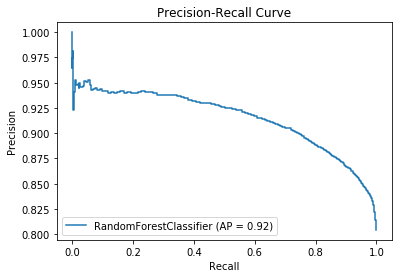

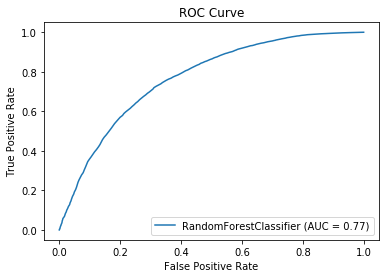

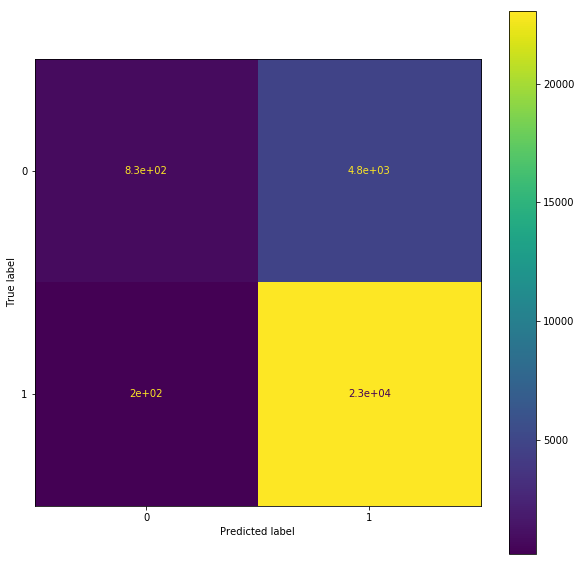

0.9016733130033623


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


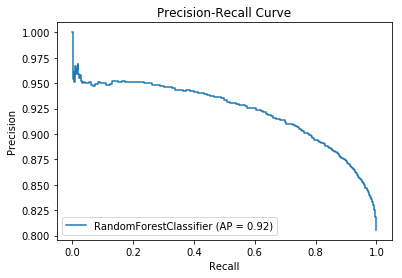

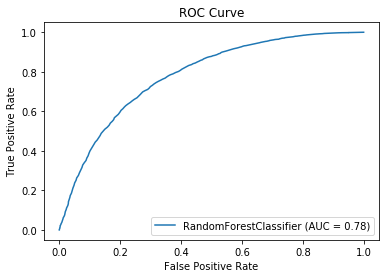

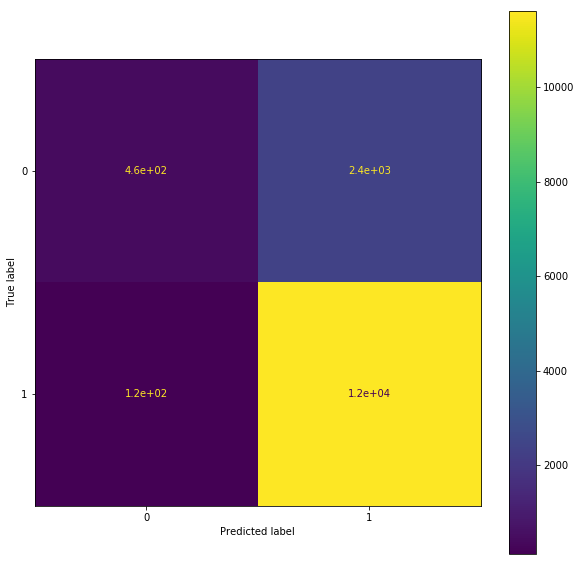

0.9033236151603499


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


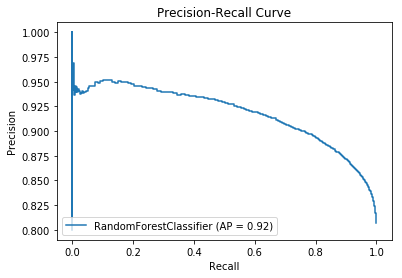

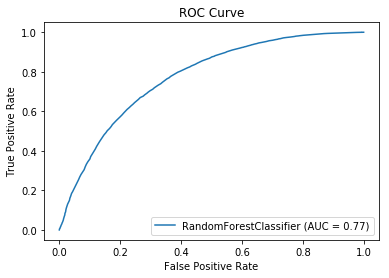

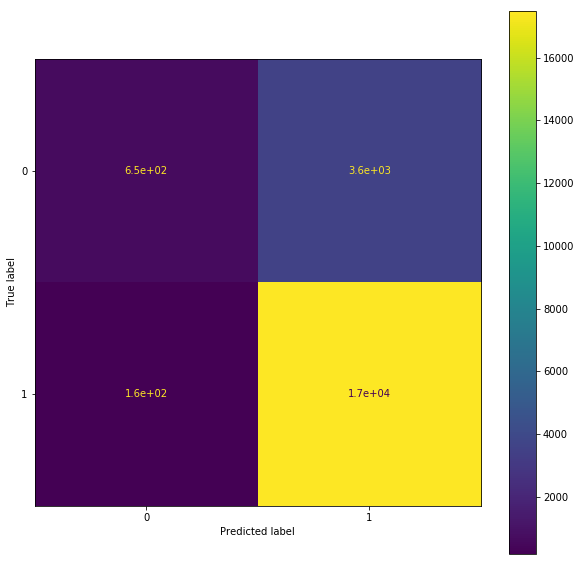

0.9028662831196306


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


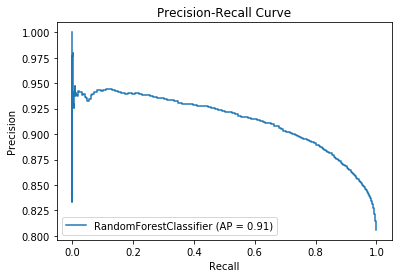

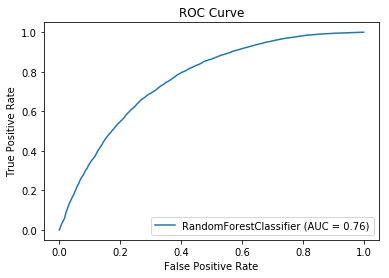

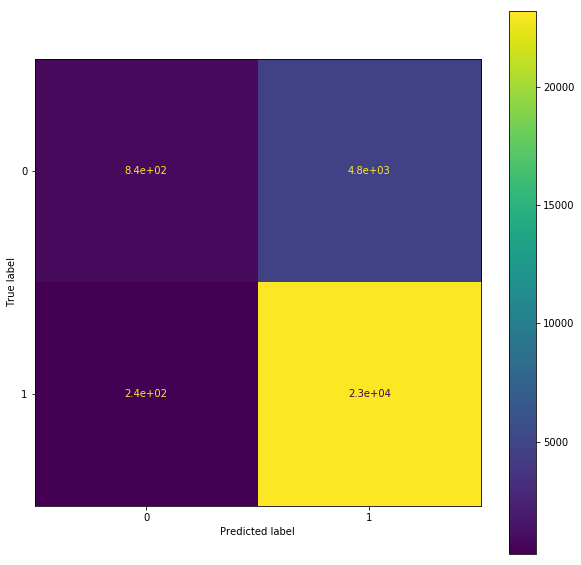

0.9019142940433388


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


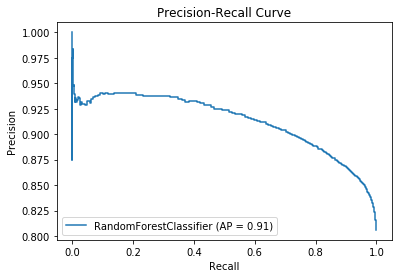

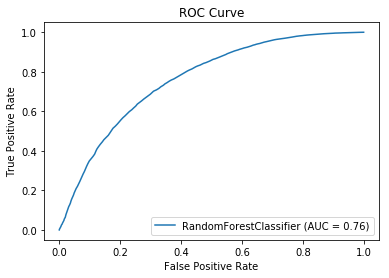

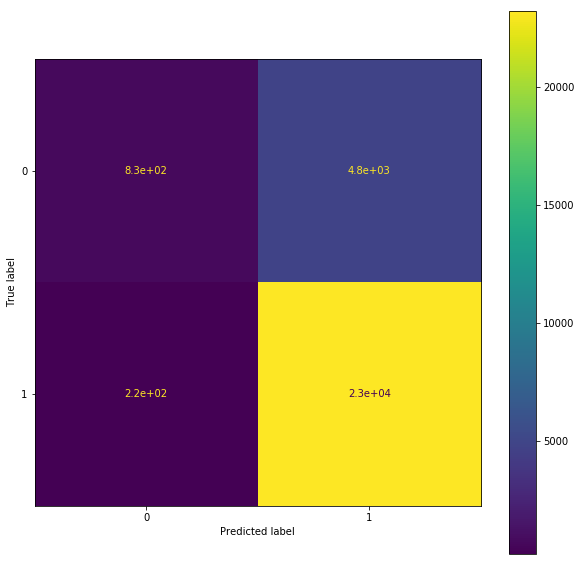

0.902136752136752


In [158]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['RACE']]
    train_x = train_df[msk].drop(columns = ['RACE'])
    test_y = train_df[~msk][['RACE']]
    test_x = train_df[~msk].drop(columns = ['RACE'])
    clf = RandomForestClassifier(n_estimators = 500)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


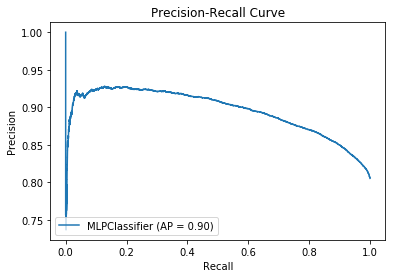

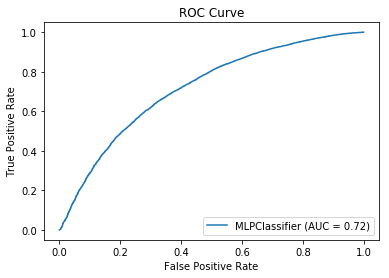

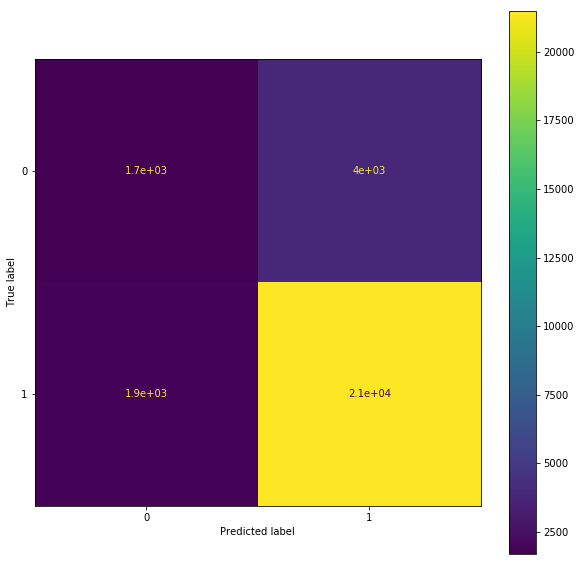

0.8799345134554385


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


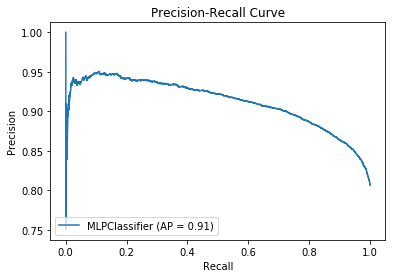

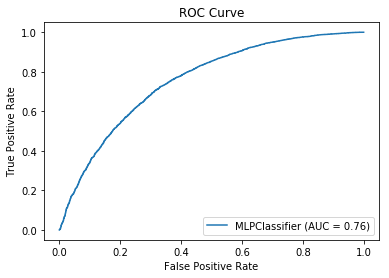

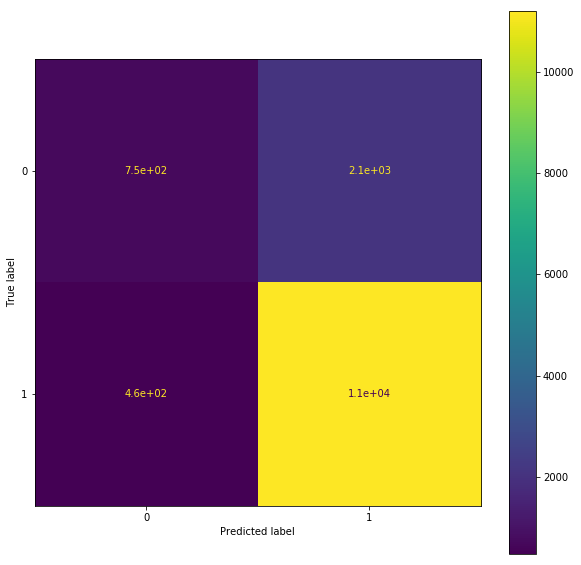

0.8982745506225228


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


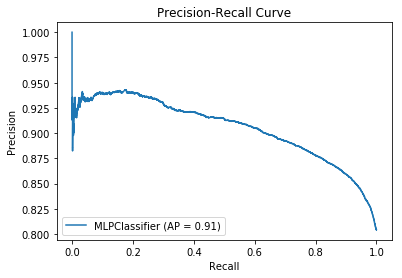

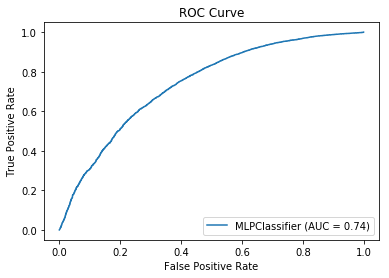

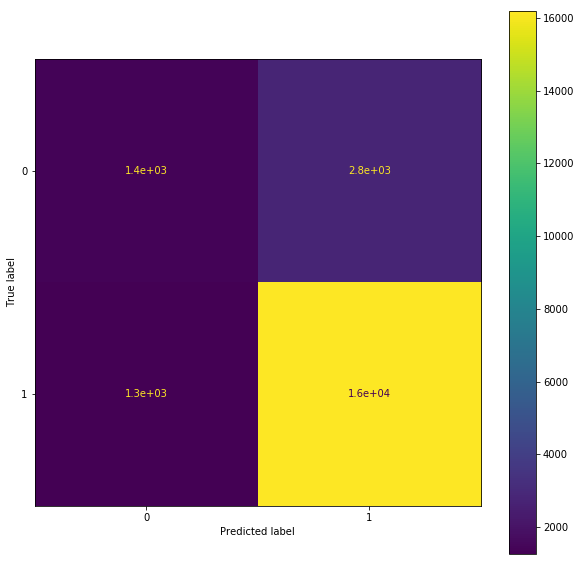

0.8881761109740384


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


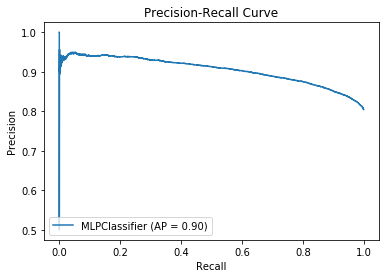

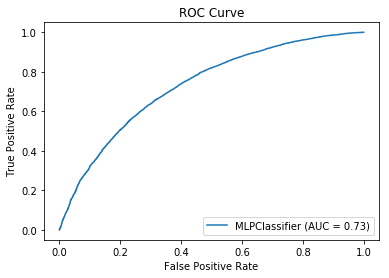

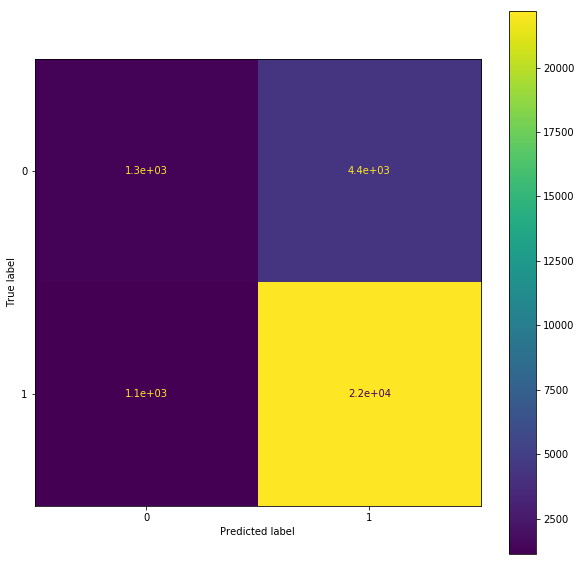

0.8902431690154964


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


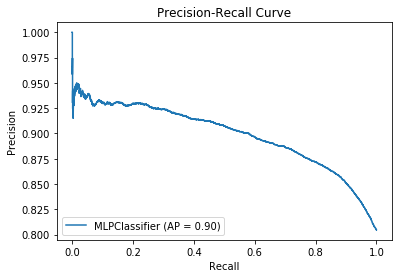

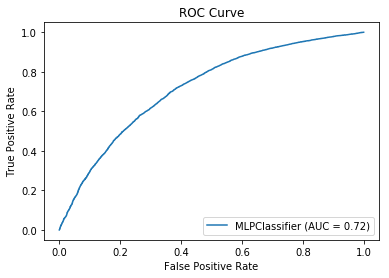

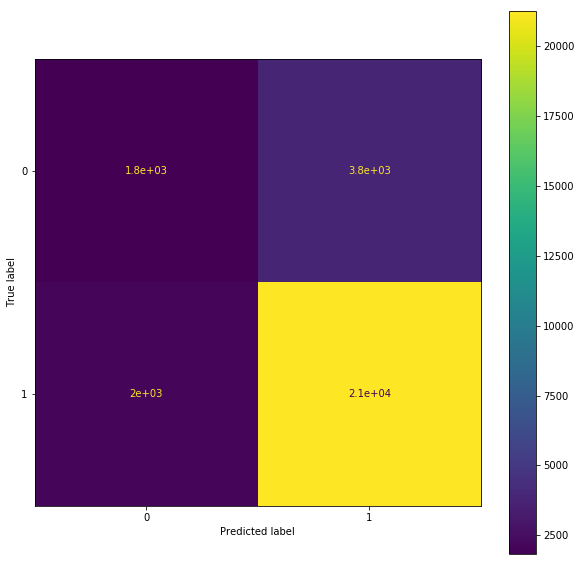

0.8783398719801776


In [159]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['RACE']]
    train_x = train_df[msk].drop(columns = ['RACE'])
    test_y = train_df[~msk][['RACE']]
    test_x = train_df[~msk].drop(columns = ['RACE'])
    clf = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


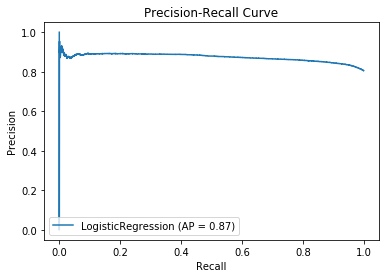

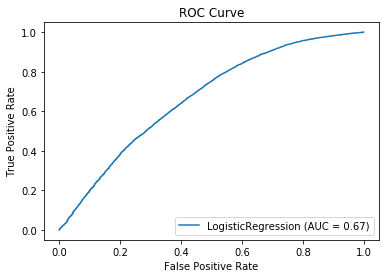

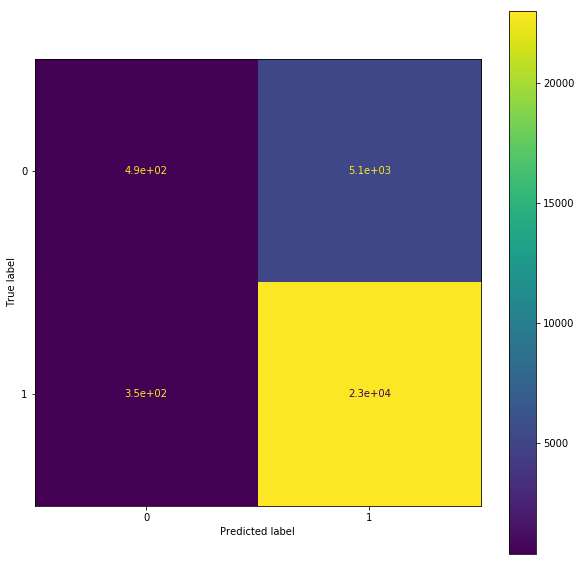

0.8934524965999612


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


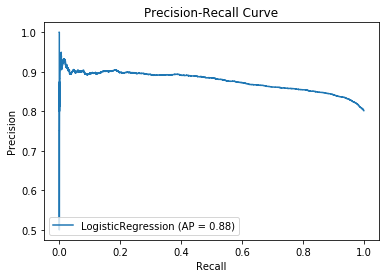

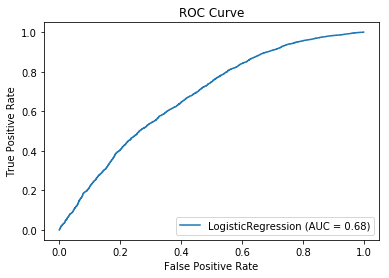

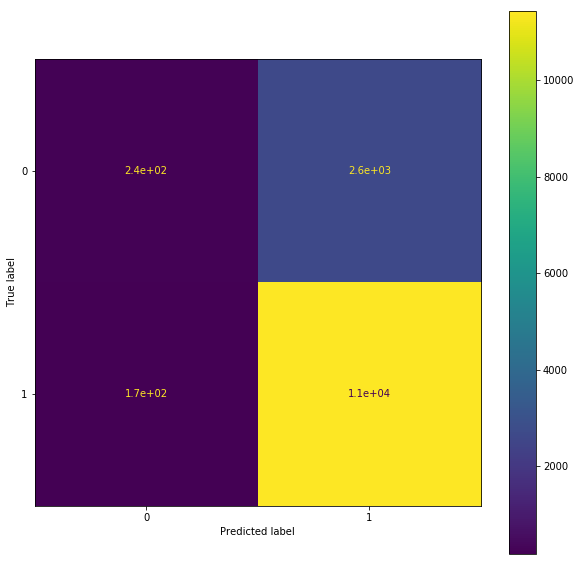

0.890774620474893


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


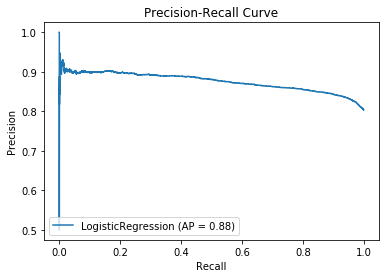

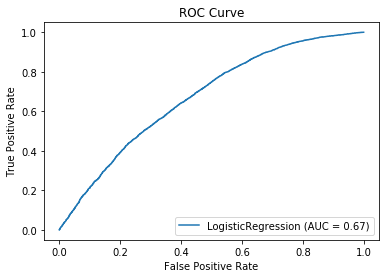

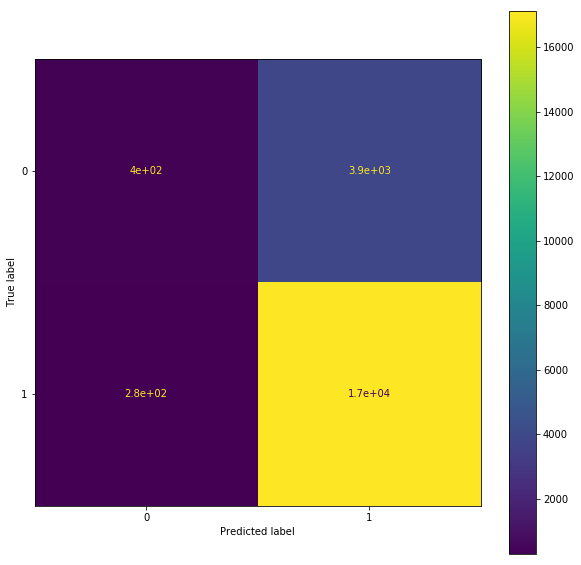

0.8919847924587261


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


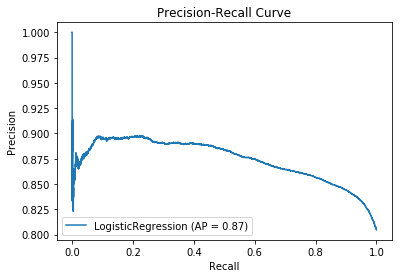

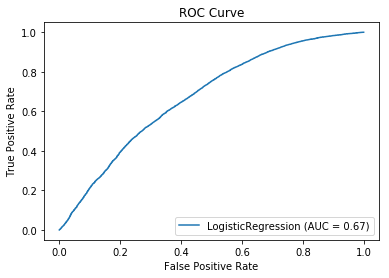

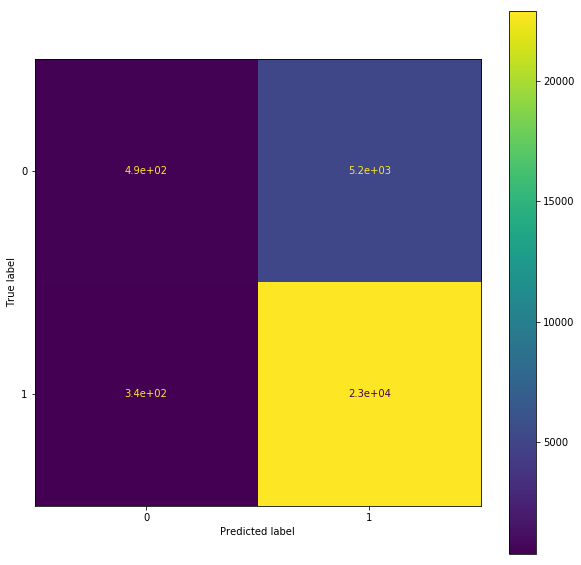

0.8929155950432546


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


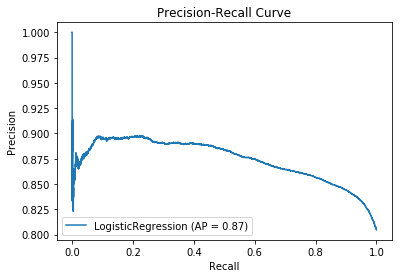

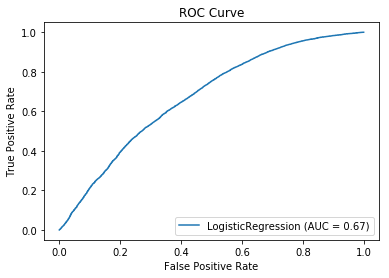

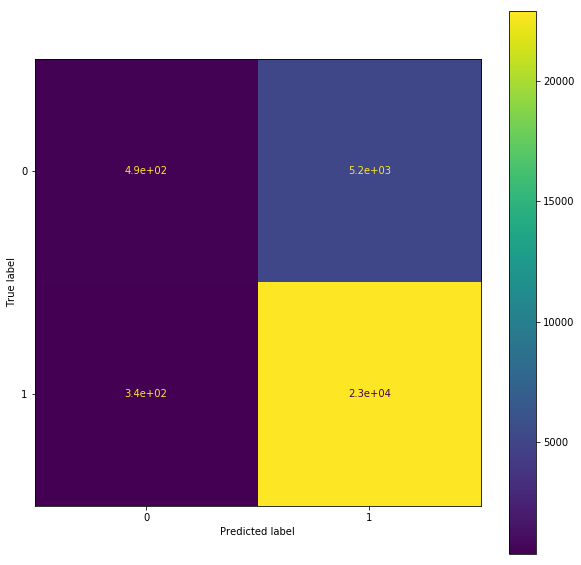

0.8929155950432546


In [160]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['RACE']]
    train_x = train_df[msk].drop(columns = ['RACE'])
    test_y = train_df[~msk][['RACE']]
    test_x = train_df[~msk].drop(columns = ['RACE'])
    clf = LogisticRegression(random_state=0)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

# Insurance Status Imputation

In [56]:
patient_details = pd.read_csv('patient_details_with_icd_codes.csv')

In [57]:
patient_details['INSURANCE'].value_counts()

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64

In [58]:
insurance_conversions = {
    'Medicare':'Public',
    'Private':'Private',
    'Medicaid':'Public',
    'Government':'Public',
    'Self Pay':'Private'
}

In [59]:
def get_public_private(insurance):
    return insurance_conversions[insurance]

In [60]:
patient_details['INSURANCE'] = patient_details['INSURANCE'].apply(get_public_private)

In [61]:
categories = ['INSURANCE', 'ETHNICITY', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS']
for category in categories:
    patient_details[category] = patient_details[category].astype('category')
    patient_details[category] = patient_details[category].cat.codes

In [62]:
patient_details = patient_details.drop_duplicates(subset = 'SUBJECT_ID', keep = 'last')
patient_details = pd.merge(patient_details, notes_race_patient, on = ['SUBJECT_ID'])
patient_details = patient_details.drop(columns = ['SUBJECT_ID', 'DIAGNOSIS'])

In [63]:
patient_details.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,486,56400,40391,D509,M1990,...,TF4990,TF4991,TF4992,TF4993,TF4994,TF4995,TF4996,TF4997,TF4998,TF4999
0,0,-1,19,2,36,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255395
1,1,50,3,2,36,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0,-1,16,4,36,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0,-1,19,2,36,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1,-1,3,4,35,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [64]:
columns_to_drop = []
for column in patient_details.columns:
    column_1 = patient_details['INSURANCE']
    column_2 = patient_details[column]
    correlation = column_1.corr(column_2) 
    if correlation > 0.04:
        print(str(column) + ': ' + str(correlation))
    else:
        if column[:2] == 'TF':
            columns_to_drop.append(column)

INSURANCE: 1.0
LANGUAGE: 0.1299219049502752
MARITAL_STATUS: 0.26932859664571474
TF1: 0.05180518693358236
TF5: 0.059345095992909346
TF7: 0.04345577154106179
TF9: 0.058489891528988626
TF23: 0.041308947721862256
TF25: 0.04663156439731318
TF26: 0.04492880489964756
TF32: 0.045713557714008216
TF39: 0.04339710971732077
TF51: 0.049537145468247064
TF52: 0.11085959894633693
TF58: 0.05639064642933807
TF69: 0.04182610228867378
TF77: 0.07713000550121155
TF82: 0.0428478024162406
TF88: 0.04054000978486667
TF98: 0.05098361023637843
TF100: 0.048868132243220605
TF105: 0.11382114867506343
TF106: 0.04184246113361633
TF116: 0.044800860180242104
TF119: 0.04418237988199029
TF120: 0.0745234516100434
TF124: 0.0530004695219815
TF133: 0.09983828424598136
TF138: 0.047697793131626476
TF149: 0.042905694591232585
TF151: 0.046184295779638826
TF156: 0.10614169852446537
TF161: 0.05443230387202329
TF163: 0.06248754493456206
TF165: 0.05039399842985037
TF168: 0.05820294740582861
TF169: 0.06515880142434359
TF180: 0.0861635

TF1940: 0.09141225326649327
TF1941: 0.05721271141332498
TF1953: 0.05103360509175232
TF1954: 0.045630687437948035
TF1965: 0.05599491734823364
TF1967: 0.14083258472972732
TF1968: 0.04222905395364151
TF1984: 0.04919973353001862
TF1999: 0.07471500745326999
TF2004: 0.07775578539000731
TF2005: 0.04738514075000971
TF2015: 0.042768743774627194
TF2016: 0.05032405543885003
TF2027: 0.050320616255570244
TF2030: 0.04359377409694833
TF2034: 0.06281469272750924
TF2035: 0.04301474906812638
TF2040: 0.045281258987304715
TF2041: 0.09747568572360273
TF2047: 0.052270981162353986
TF2050: 0.08160399241488825
TF2052: 0.08922494093276305
TF2054: 0.10323825179223331
TF2055: 0.04854739047530616
TF2057: 0.12456064750698613
TF2063: 0.06372864645368377
TF2064: 0.06321793930521946
TF2084: 0.04845039440343041
TF2085: 0.05406204178077754
TF2087: 0.12170354033580344
TF2088: 0.04247926624689572
TF2089: 0.07712959964461667
TF2099: 0.04043886946248352
TF2103: 0.09879112696764093
TF2104: 0.07210503147837784
TF2107: 0.06814

TF3960: 0.05375835789597283
TF3968: 0.04120560725213542
TF3970: 0.10269909015956034
TF3972: 0.04776295580354771
TF3973: 0.045197443434398535
TF3981: 0.040237182229386735
TF3987: 0.04287997797715937
TF3996: 0.11328454200575429
TF4001: 0.07152468213262393
TF4002: 0.04895922301527755
TF4009: 0.05067951713526382
TF4012: 0.058816162149011066
TF4016: 0.047293641683647664
TF4019: 0.06888734676857852
TF4035: 0.04335528424832706
TF4036: 0.10085079471771355
TF4051: 0.08484816625419199
TF4073: 0.04072359288262614
TF4078: 0.06904376536221811
TF4097: 0.060257146574904476
TF4099: 0.07601135526290959
TF4102: 0.04769798965497251
TF4110: 0.09325693128068928
TF4112: 0.054112735100027544
TF4116: 0.10664010277959386
TF4123: 0.05789786196723059
TF4125: 0.04983432379062272
TF4130: 0.06919796079461212
TF4146: 0.055574361734168826
TF4161: 0.05880002123866246
TF4174: 0.04048361492141686
TF4187: 0.05159398214855003
TF4192: 0.06312590783977007
TF4202: 0.0956882234367279
TF4229: 0.04474032421201779
TF4231: 0.0759

In [65]:
patient_details = patient_details.drop(columns = columns_to_drop)

In [66]:
msk = np.random.rand(len(patient_details)) < 0.8
train_df = patient_details[msk]
test_df = patient_details[~msk]

C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


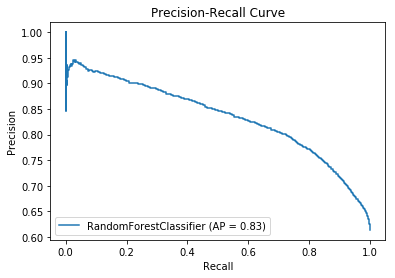

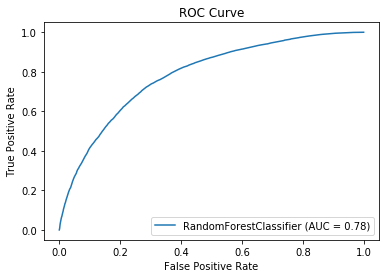

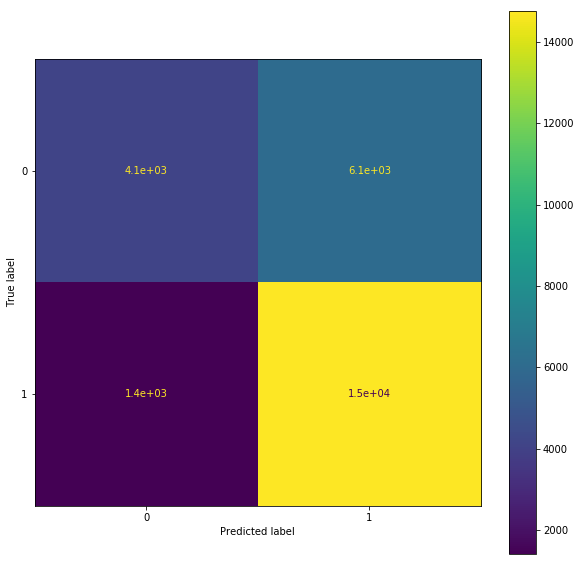

0.7979795251343831


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


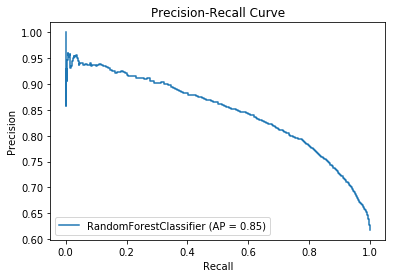

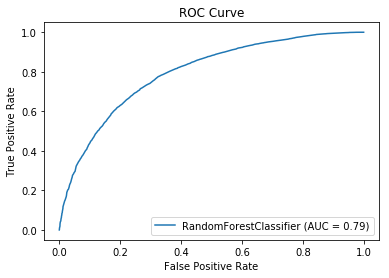

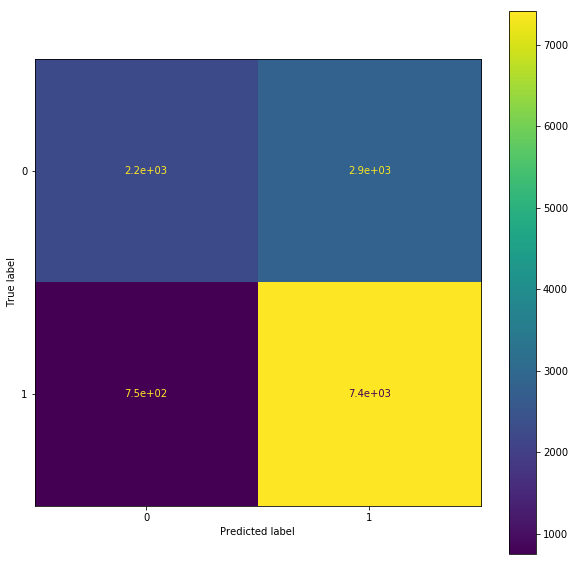

0.804358432265409


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


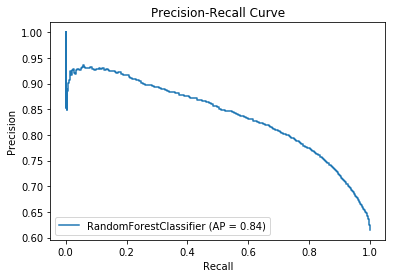

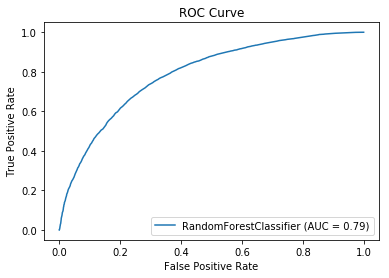

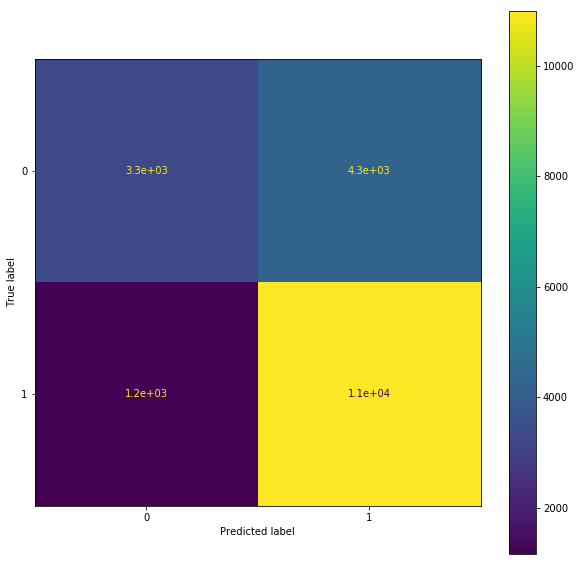

0.8014863929469198


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


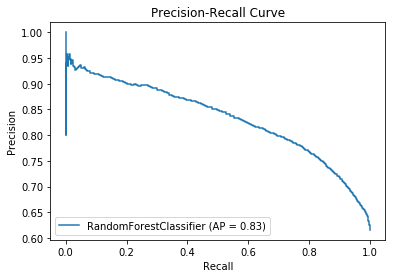

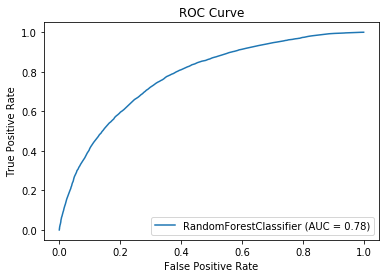

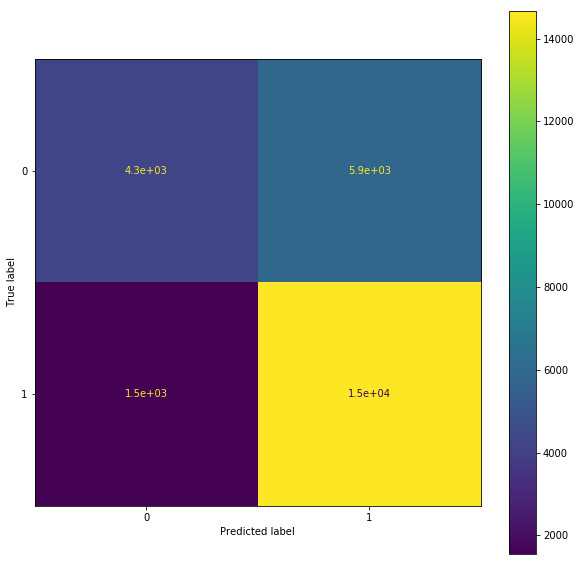

0.7986175366026235


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


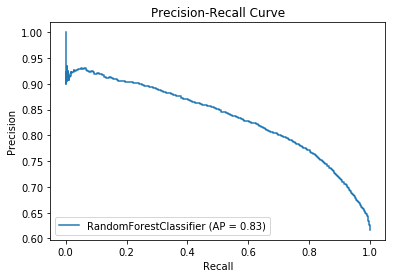

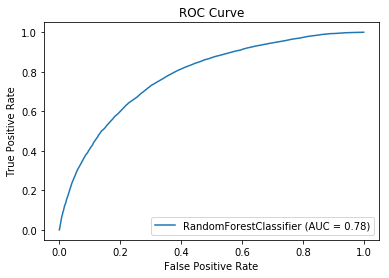

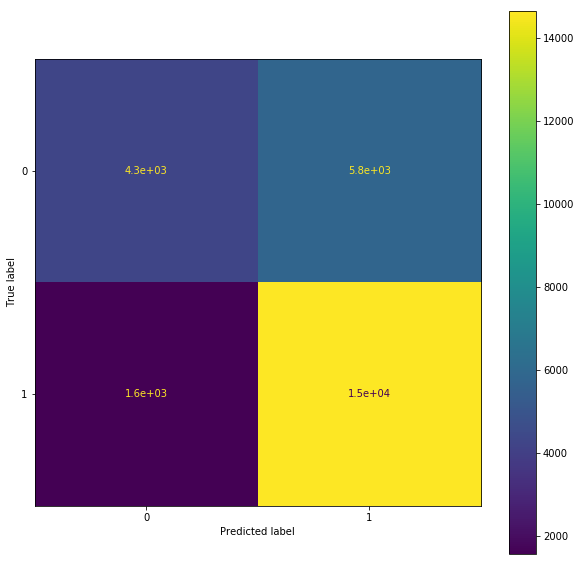

0.7984411620428409


In [68]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['INSURANCE']]
    train_x = train_df[msk].drop(columns = ['INSURANCE'])
    test_y = train_df[~msk][['INSURANCE']]
    test_x = train_df[~msk].drop(columns = ['INSURANCE'])
    clf = RandomForestClassifier(n_estimators = 500)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


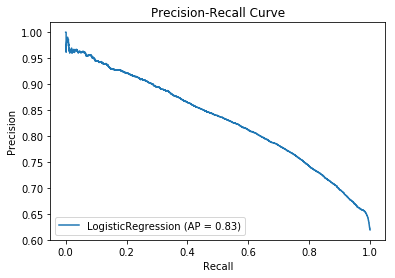

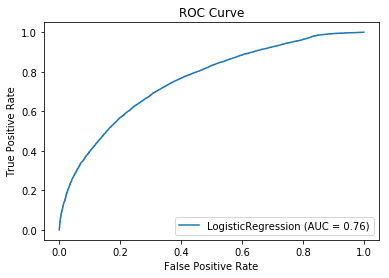

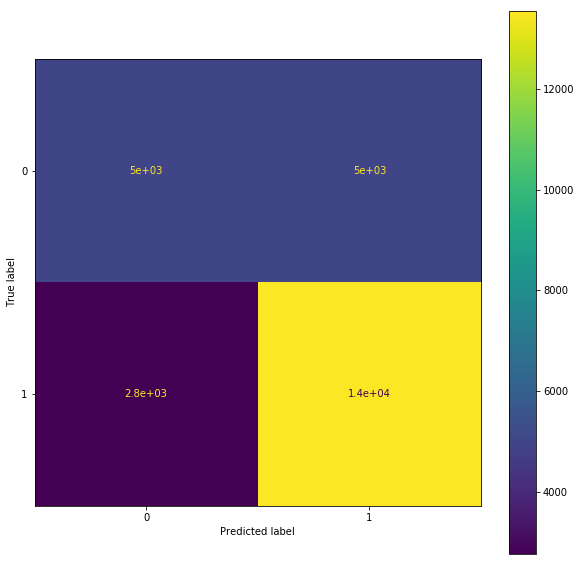

0.7772169324308821


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


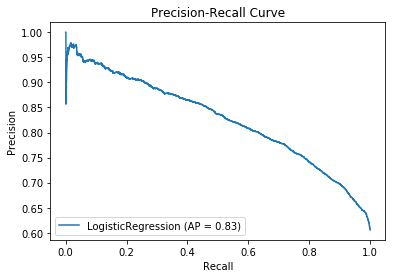

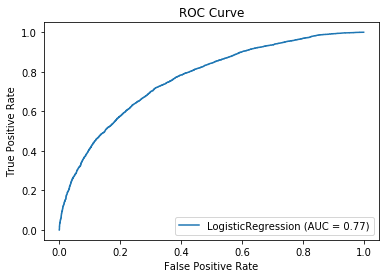

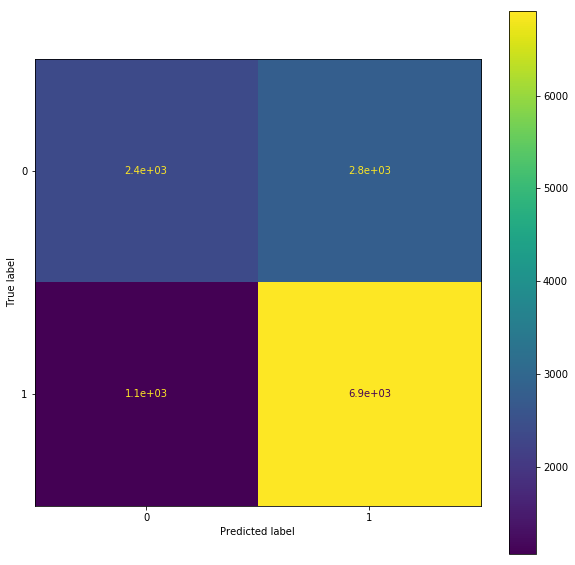

0.7809588344909368


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


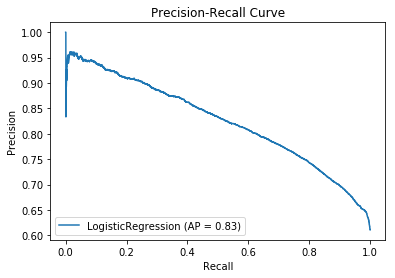

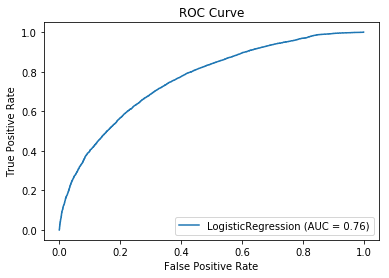

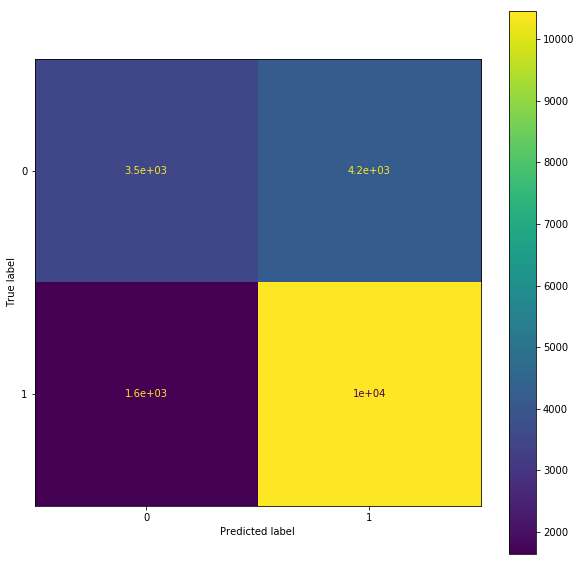

0.7816538432807948


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


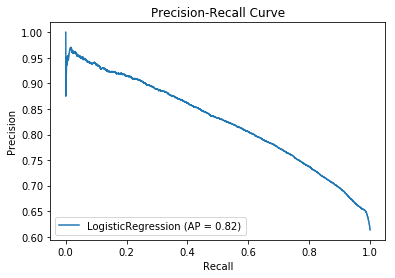

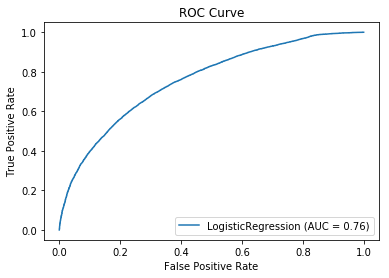

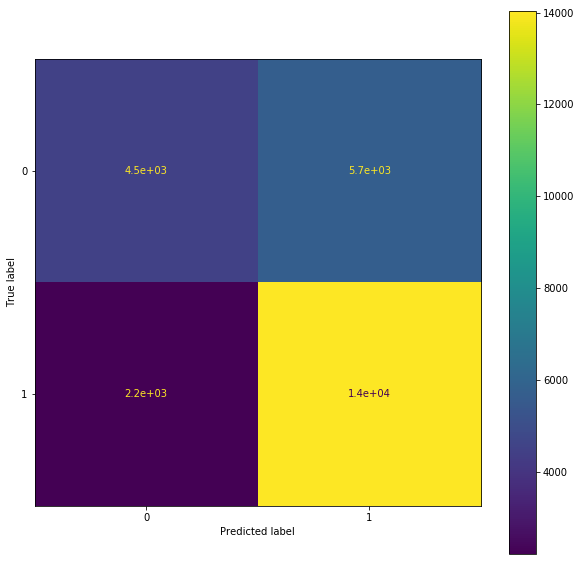

0.7797984285198656


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


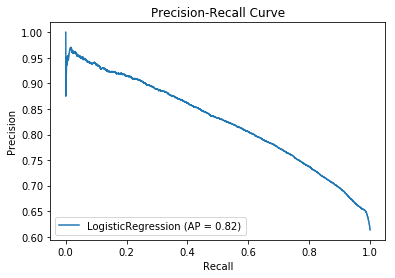

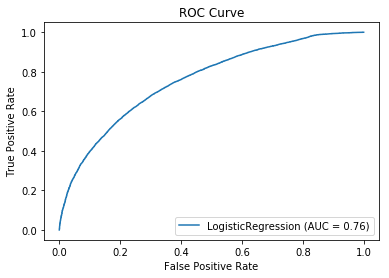

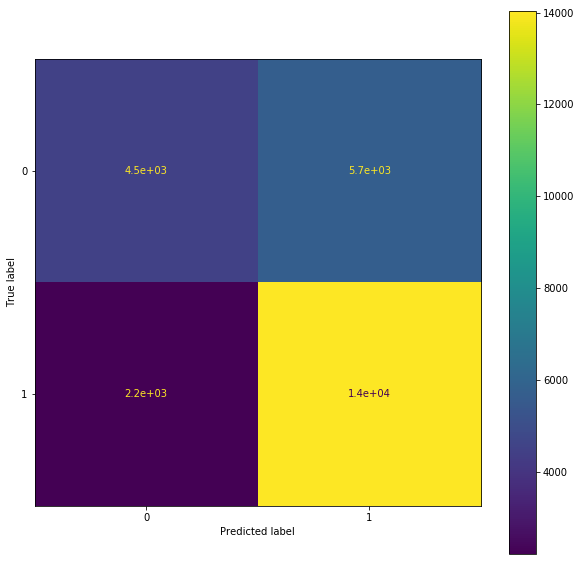

0.7797984285198656


In [70]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:    
    train_y = train_df[msk][['INSURANCE']]
    train_x = train_df[msk].drop(columns = ['INSURANCE'])
    test_y = train_df[~msk][['INSURANCE']]
    test_x = train_df[~msk].drop(columns = ['INSURANCE'])
    clf = LogisticRegression(random_state=0)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


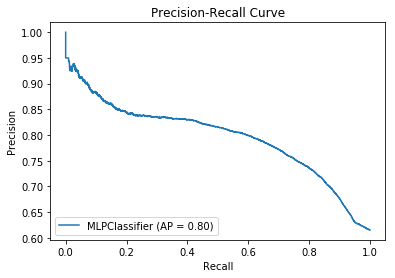

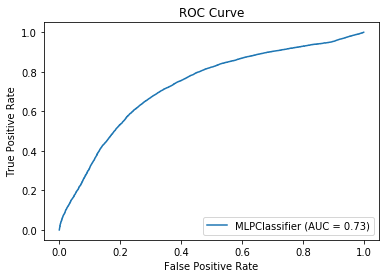

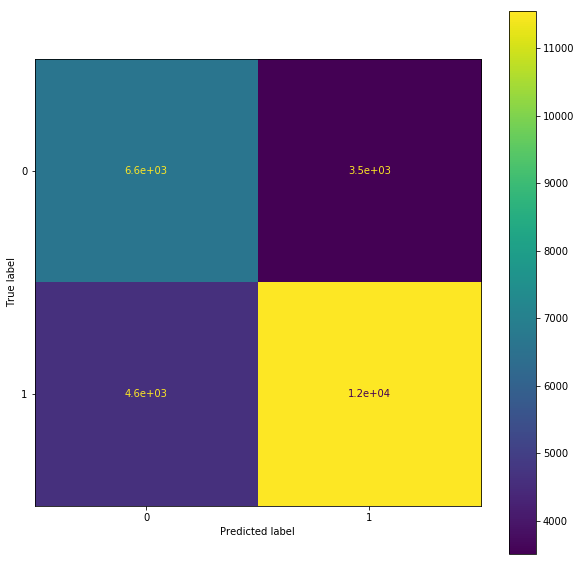

0.7396716694934238


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


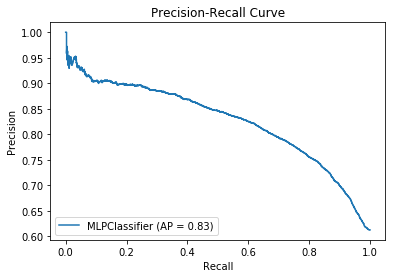

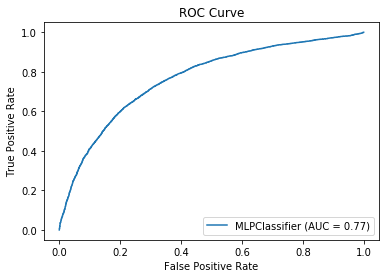

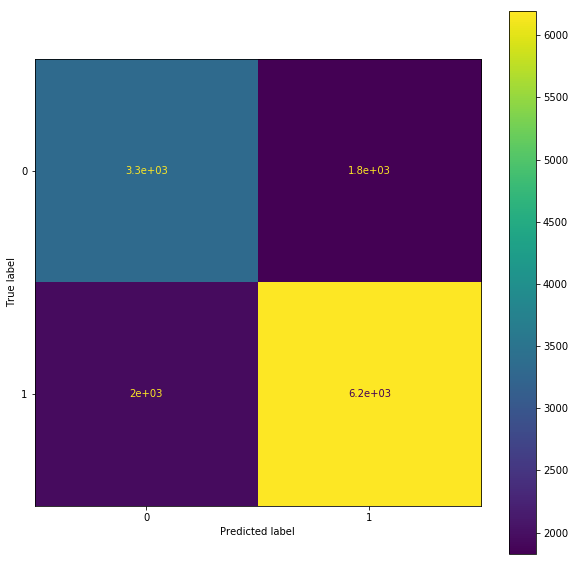

0.7661494714718426


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


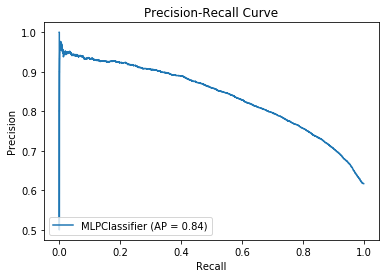

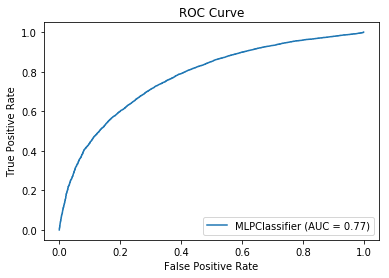

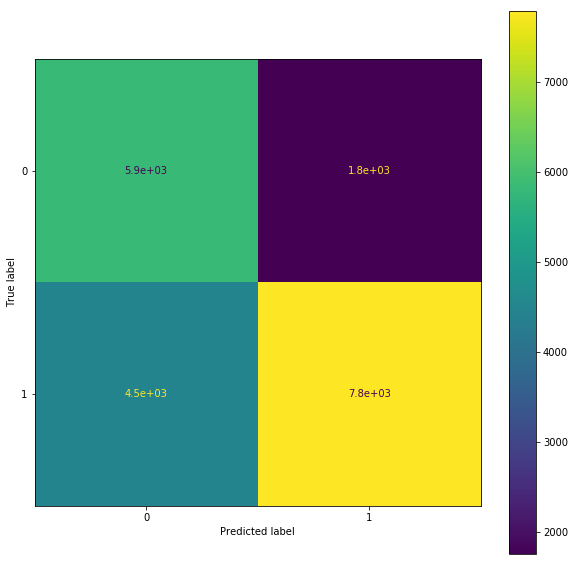

0.7145150194909423


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


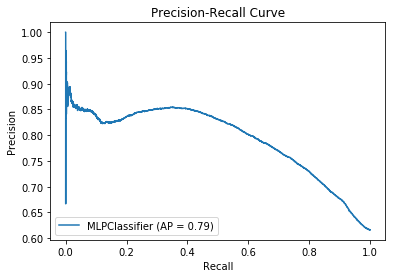

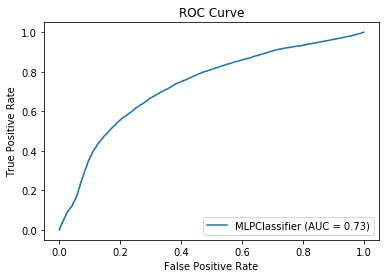

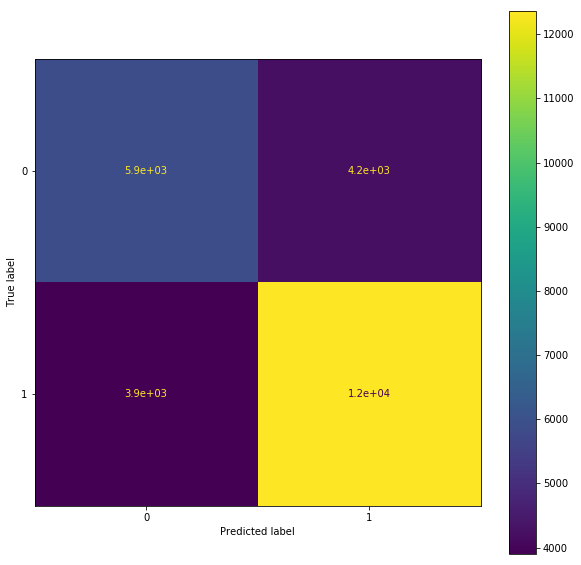

0.7526318992271648


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


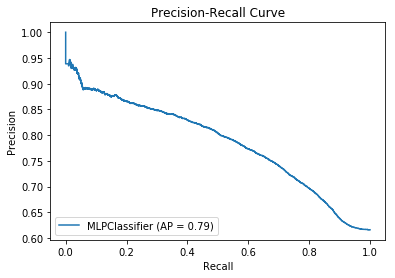

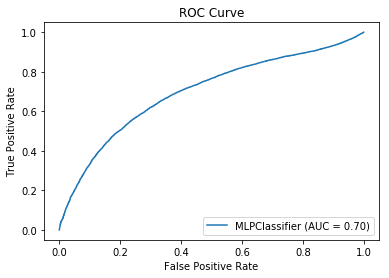

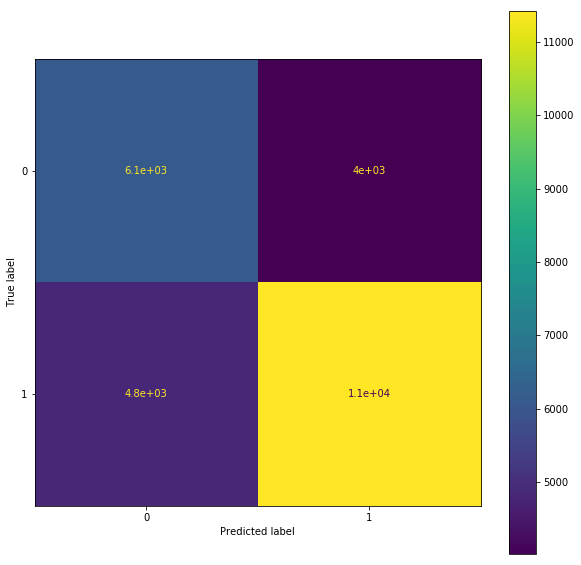

0.7204769114307343


In [71]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:    
    train_y = train_df[msk][['INSURANCE']]
    train_x = train_df[msk].drop(columns = ['INSURANCE'])
    test_y = train_df[~msk][['INSURANCE']]
    test_x = train_df[~msk].drop(columns = ['INSURANCE'])
    clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

# Marital Status Imputation

In [104]:
patient_details = pd.read_csv('patient_details_with_icd_codes.csv')

In [105]:
patient_details['MARITAL_STATUS'].value_counts()

MARRIED              24239
SINGLE               13254
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [106]:
marriage_conversions = {
    'MARRIED' : 'Not Single',
    'SINGLE' : 'Single',
    'DIVORCED' : 'Single',
    'SEPARATED' : 'Single',
    'WIDOWED' : 'Single',
    'UNKNOWN (DEFAULT)' : 'Unknown',
    'LIFE PARTNER' : 'Not Single'
}

In [107]:
def get_single(marital_status):
    if marital_status not in marriage_conversions:
        return 'Unknown'
    return marriage_conversions[marital_status]

In [108]:
patient_details['MARITAL_STATUS'] = patient_details['MARITAL_STATUS'].apply(get_single)

In [109]:
patient_details['MARITAL_STATUS'].value_counts()

Not Single    24254
Single        24249
Unknown       10473
Name: MARITAL_STATUS, dtype: int64

In [110]:
patient_details = patient_details[patient_details['MARITAL_STATUS'] != 'Unknown']
categories = ['INSURANCE', 'ETHNICITY', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS']
for category in categories:
    patient_details[category] = patient_details[category].astype('category')
    patient_details[category] = patient_details[category].cat.codes
patient_details = patient_details.drop_duplicates(subset = 'SUBJECT_ID', keep = 'last')
patient_details = pd.merge(patient_details, notes_race_patient, on = ['SUBJECT_ID'])
patient_details = patient_details.drop(columns = ['SUBJECT_ID', 'DIAGNOSIS'])

In [111]:
patient_details['MARITAL_STATUS'].value_counts()

0    17991
1    17201
Name: MARITAL_STATUS, dtype: int64

In [112]:
columns_to_drop = []
for column in patient_details.columns:
    column_1 = patient_details['MARITAL_STATUS']
    column_2 = patient_details[column]
    correlation = column_1.corr(column_2) 
    if correlation > 0.04:
        print(str(column) + ': ' + str(correlation))
    else:
        if column[:2] == 'TF':
            columns_to_drop.append(column)

RELIGION: 0.042898438735220944
MARITAL_STATUS: 1.0
TF22: 0.10598615001506087
TF36: 0.0641700295054666
TF37: 0.06793697130873844
TF52: 0.045839596932894834
TF82: 0.04209184758996937
TF112: 0.040081087716714384
TF119: 0.04001008690573182
TF125: 0.04473912895975359
TF128: 0.040628804957976064
TF133: 0.062411459328115856
TF134: 0.07064255484030728
TF156: 0.22646475371919897
TF189: 0.05637066859920262
TF217: 0.0503162587088759
TF235: 0.042292084741179396
TF240: 0.04020830048190227
TF245: 0.04127382044386825
TF253: 0.044907232219021535
TF312: 0.04431437048584358
TF337: 0.04040035086381044
TF417: 0.06719899224457933
TF418: 0.0693891760221317
TF425: 0.06528242456070978
TF431: 0.047976940432935156
TF432: 0.04045198241554376
TF469: 0.04209734038770539
TF497: 0.06976876176209369
TF525: 0.06685627806679333
TF526: 0.06932672424570642
TF537: 0.05463514499963897
TF543: 0.06710907210260553
TF544: 0.04109990687105059
TF582: 0.045538197582179564
TF601: 0.06660275527364319
TF618: 0.04941738547963913
TF64

In [113]:
patient_details = patient_details.drop(columns = columns_to_drop)

In [114]:
train_df = patient_details

C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


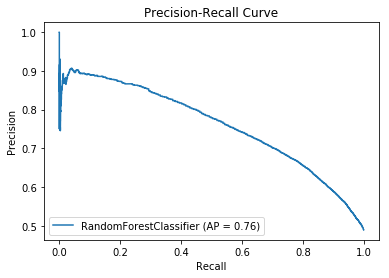

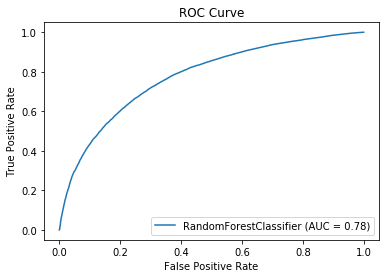

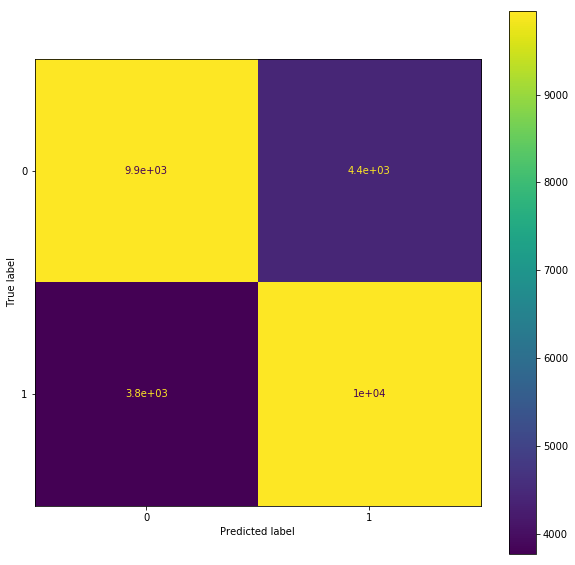

0.7085958355579284


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


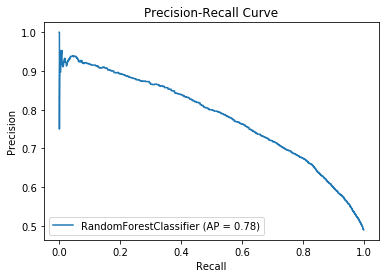

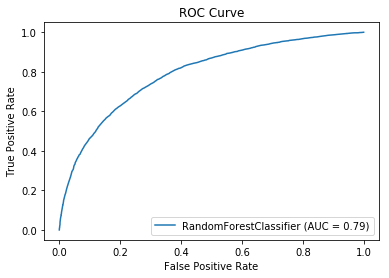

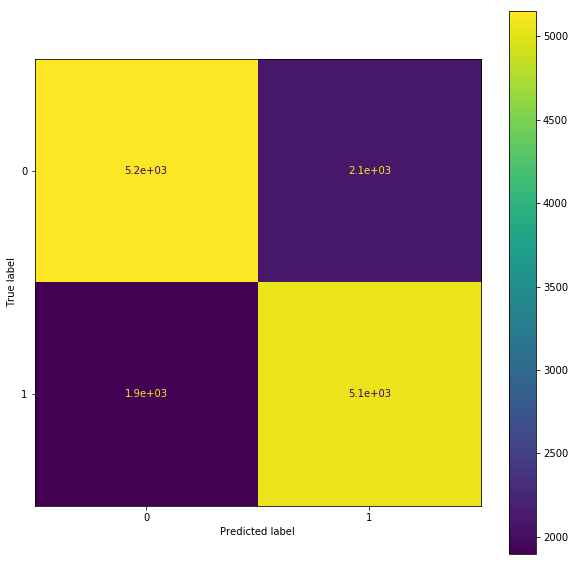

0.7168179239931932


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


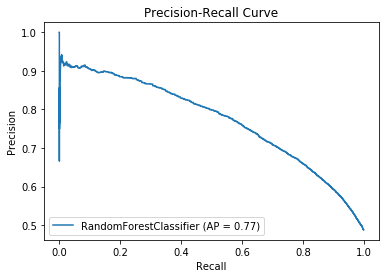

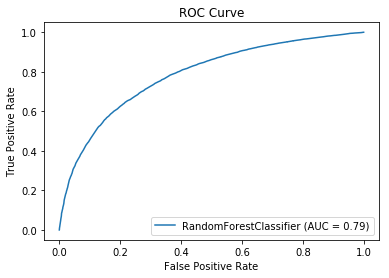

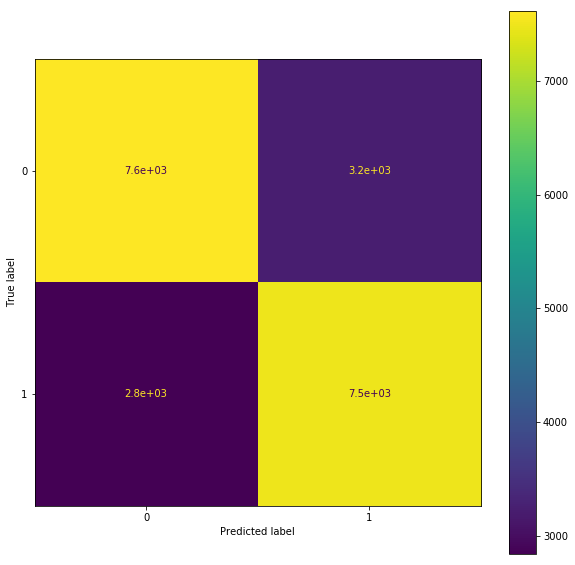

0.711825814714672


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


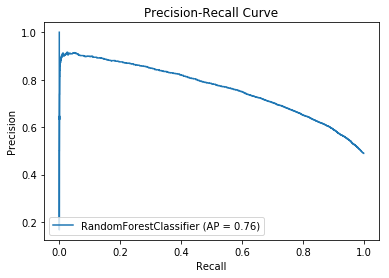

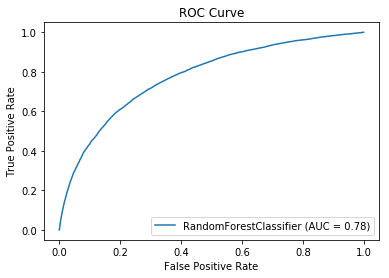

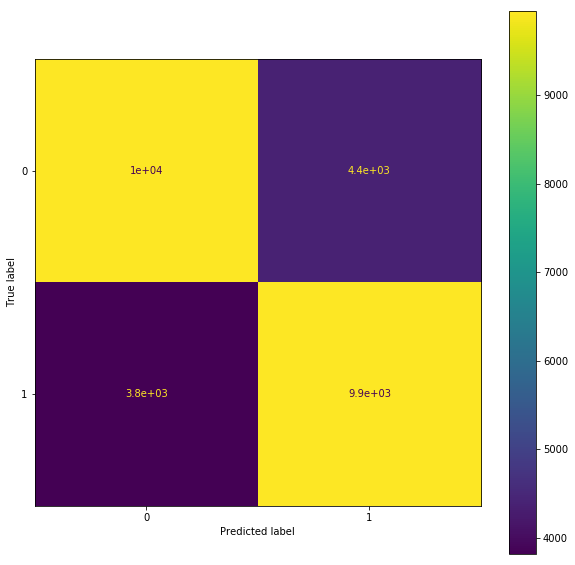

0.7076988757649066


C:\Users\aurno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


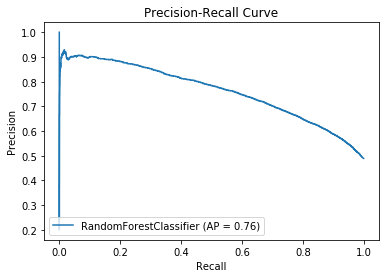

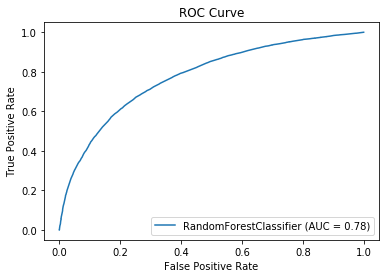

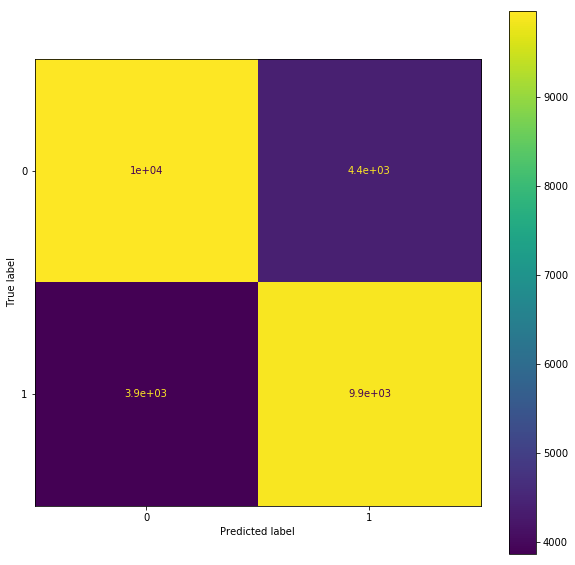

0.7058571886920253


In [115]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['MARITAL_STATUS']]
    train_x = train_df[msk].drop(columns = ['MARITAL_STATUS'])
    test_y = train_df[~msk][['MARITAL_STATUS']]
    test_x = train_df[~msk].drop(columns = ['MARITAL_STATUS'])
    clf = RandomForestClassifier(n_estimators = 500)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


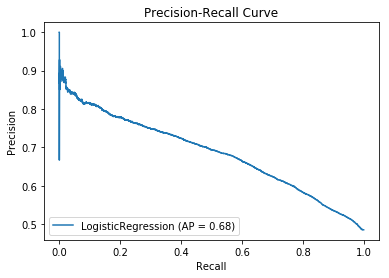

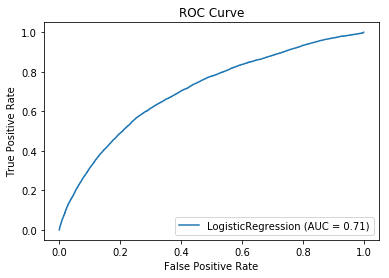

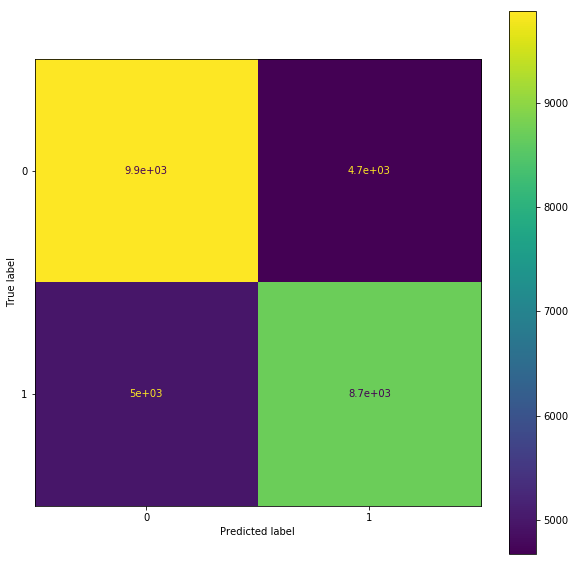

0.6431314623338257


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


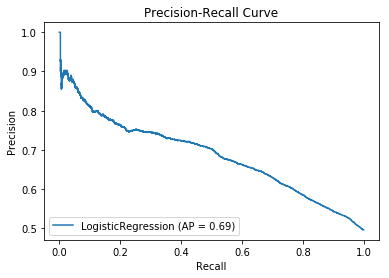

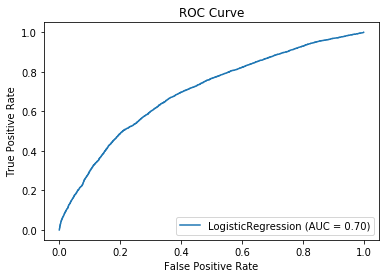

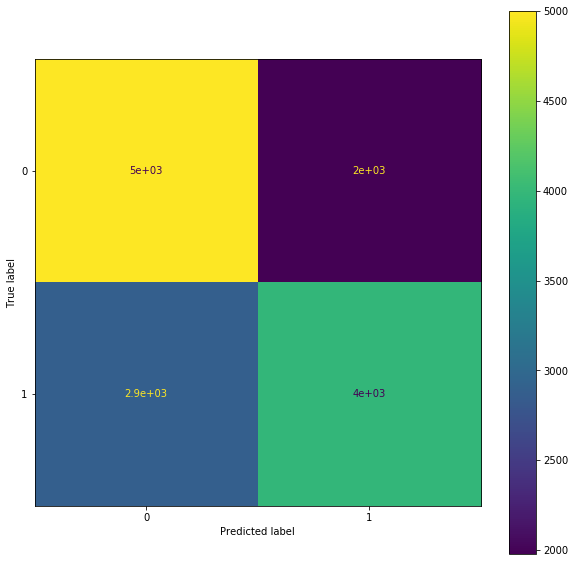

0.6206950288296712


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


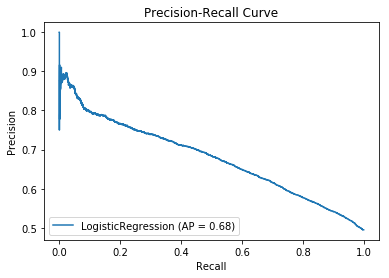

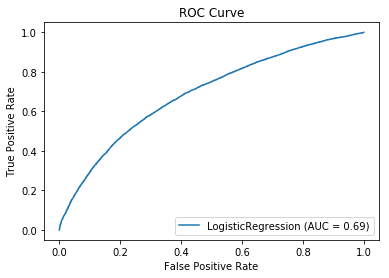

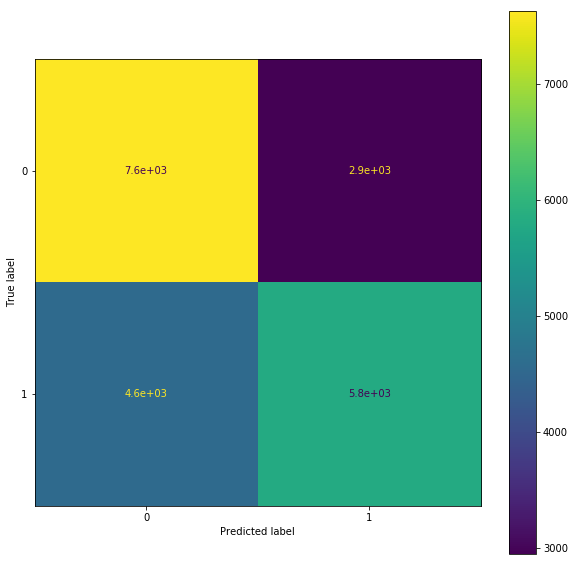

0.6073260073260073


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


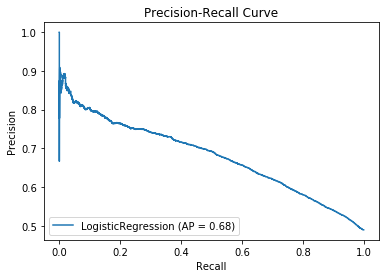

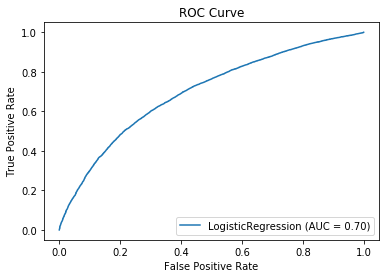

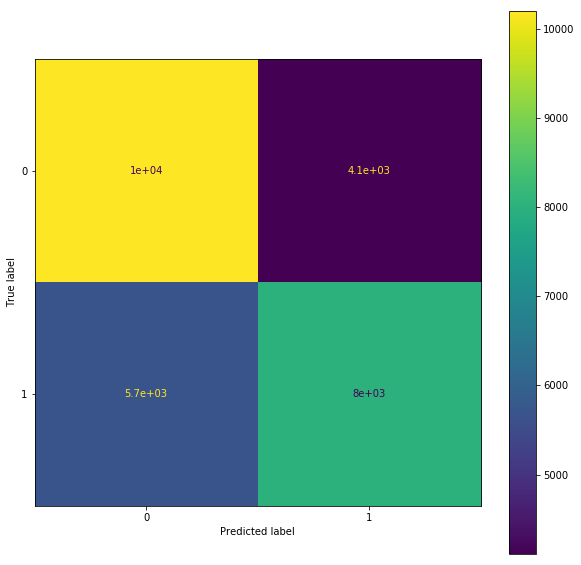

0.6204973274459679


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


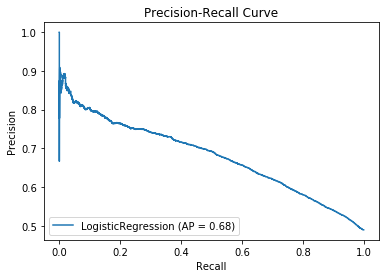

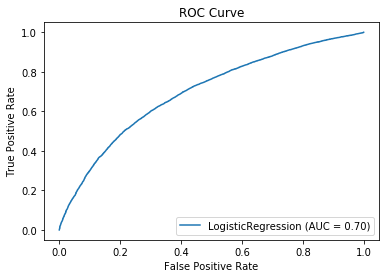

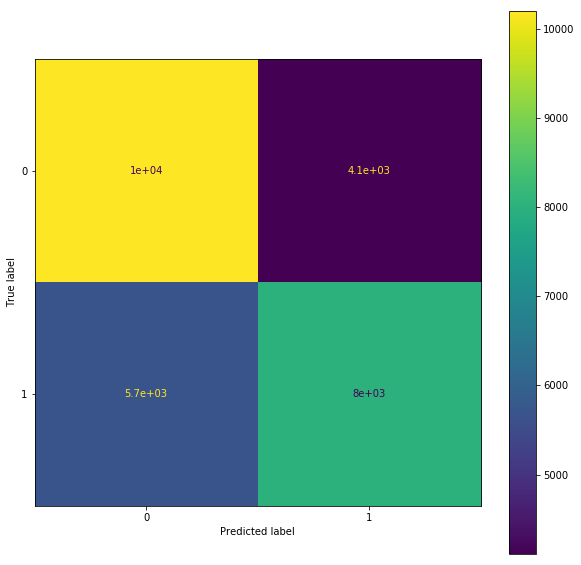

0.6204973274459679


In [116]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['MARITAL_STATUS']]
    train_x = train_df[msk].drop(columns = ['MARITAL_STATUS'])
    test_y = train_df[~msk][['MARITAL_STATUS']]
    test_x = train_df[~msk].drop(columns = ['MARITAL_STATUS'])
    clf = LogisticRegression(random_state=0)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))

C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


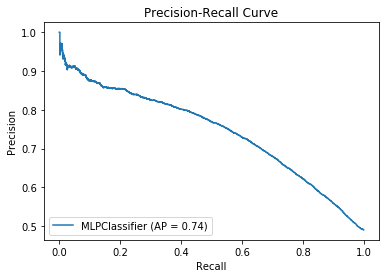

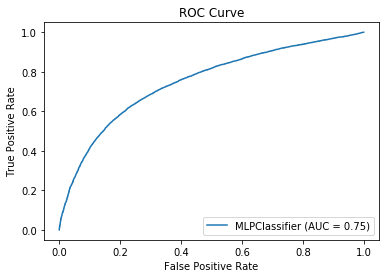

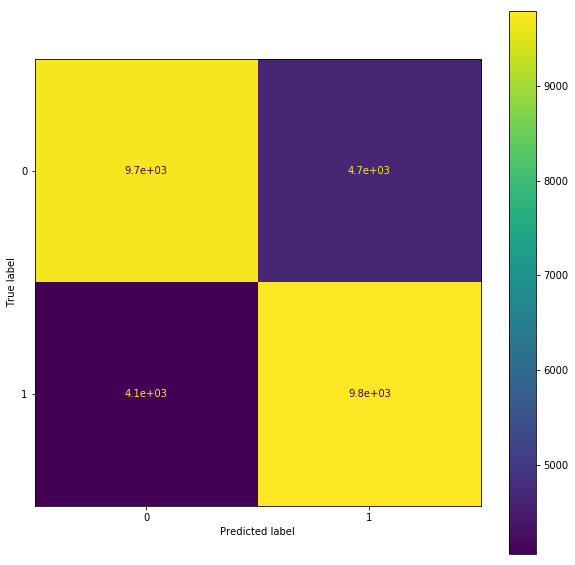

0.6917808219178082


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


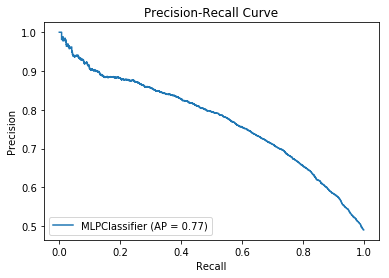

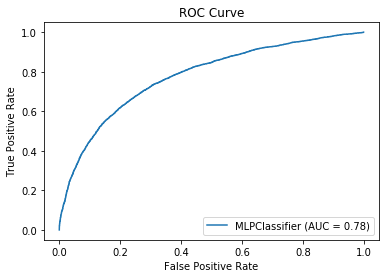

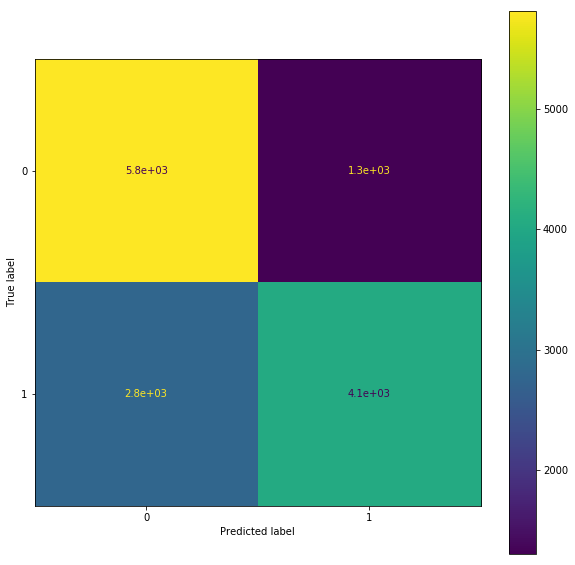

0.6647536279412971


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


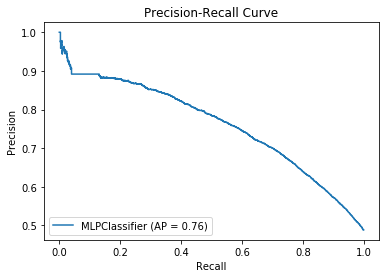

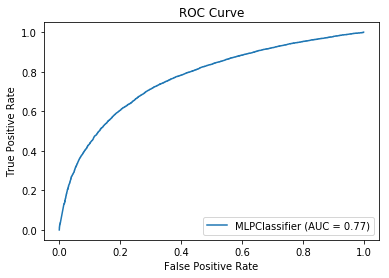

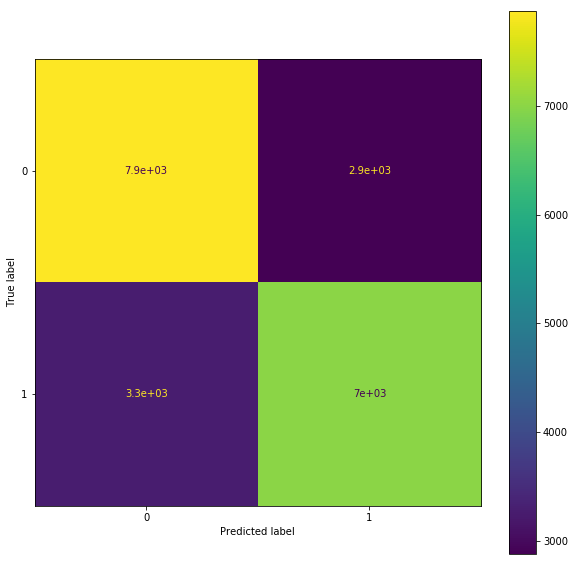

0.6945037485725635


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


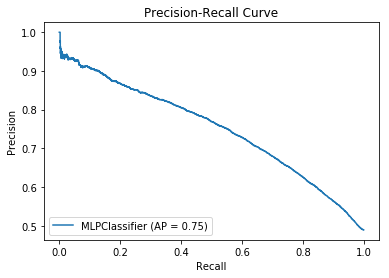

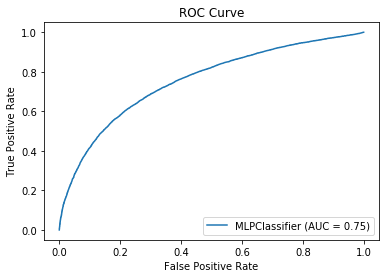

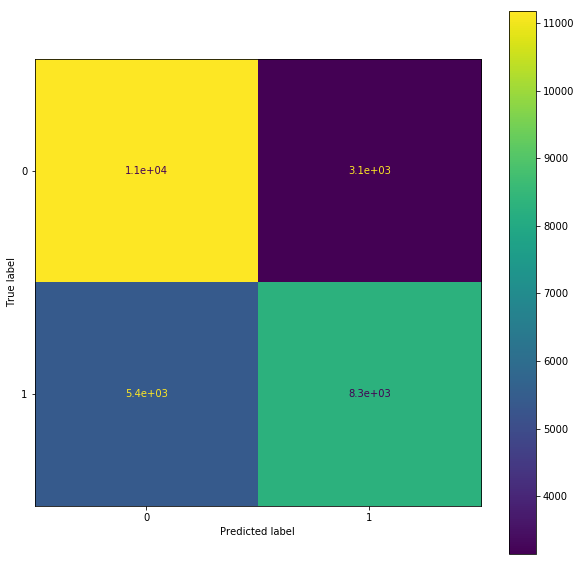

0.6602566649449719


C:\Users\aurno\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


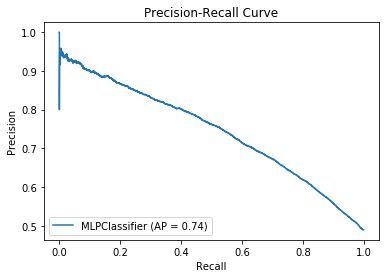

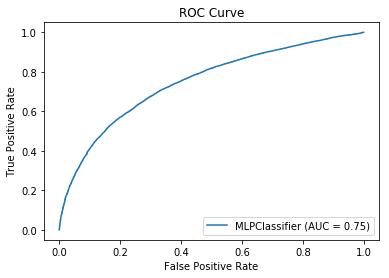

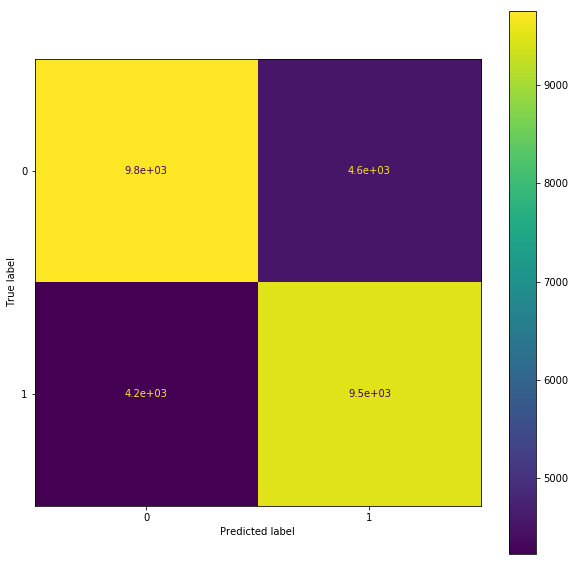

0.6839680368583975


In [117]:
msk = np.random.rand(len(train_df))
msk_1 = msk > 0.8
msk_2 = msk > 0.6
msk_2 = msk_2 <= 0.8
msk_3 = msk > 0.4
msk_3 = msk_3 <= 0.6
msk_4 = msk > 0.2
msk_4 = msk_4 <= 0.4
msk_5 = msk <= 0.2

msks = [msk_1, msk_2, msk_3, msk_4, msk_5]
for msk in msks:
    train_y = train_df[msk][['MARITAL_STATUS']]
    train_x = train_df[msk].drop(columns = ['MARITAL_STATUS'])
    test_y = train_df[~msk][['MARITAL_STATUS']]
    test_x = train_df[~msk].drop(columns = ['MARITAL_STATUS'])
    clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    clf.fit(train_x, train_y)
    
    disp = plot_precision_recall_curve(clf, test_x, test_y)
    disp.ax_.set_title('Precision-Recall Curve')
    plt.show()
    
    disp = plot_roc_curve(clf, test_x, test_y)
    disp.ax_.set_title('ROC Curve')
    plt.show()
    
    pred_test_y = clf.predict(test_x)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, test_x, test_y, ax=ax)
    plt.show()
    print(str(f1_score(test_y, pred_test_y)))